In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
from vectorDiff import *
from scipy.stats import chisquare

In [2]:
#This file is checking by not removing all of the events but just the ones that are larger than 200 meters. 

In [3]:
df = pd.read_csv('Events_iron.csv')
df2 = pd.read_csv('Events.csv')

In [4]:
df = df.loc[(df['chi2']>0)&(df['chi2']<10)&(df['zenith']<35*np.pi/180)]
df2 = df2.loc[(df2['chi2']>0)&(df['chi2']<10)&(df['zenith']<35*np.pi/180)]

In [5]:
events = df['Unnamed: 0'].unique()
events2 = df2['Unnamed: 0'].unique()

In [6]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmam', 'sigmas', 'A',
       'feimpedance', 'spemean', 'pe_per_vem', 'angular_resolution',
       'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith', 'Laputop_dir_azimuth',
       'Laputop_new_zenith', 'Laputop_new_azimuth', 'Laputop_time',
       'Laputop_pos_x', 'Laputop_pos_y', 't_0', 'Xmax'],
      dtype='object')

In [7]:
c = .299

In [8]:
def get_delta(r,a,b,sigma):
    b_start = 19.51
    sigma_start = 83.5
    delta = a * r**2.0 #+ b_start * (1-np.exp(-(r**2.0)/(2*(sigma_start**2.0))))
    return delta

In [9]:
def get_n(x,y,z):
    x,y,z = np.array([x,y,z])/(x**2.0+y**2.0+z**2.0)**0.5
    return [x,y,z]

In [10]:
def get_n_cos(zen,az):
    x = -np.sin(zen) * np.cos(az)
    y = -np.sin(zen) * np.sin(az)
    z = -np.cos(zen)
    return x,y,z

In [11]:
def rotation(X,az,zen):
    R1 = np.array([[np.cos(az),-np.sin(az),0],
                [np.sin(az),np.cos(az),0],
                [0,0,1]])
    y_new = np.dot(R1,[0,1,0])
    R2_1 = np.cos(zen)*np.array([[1,0,0],[0,1,0],[0,0,1]])
    R2_2 = np.sin(zen)*(np.outer(np.cross(y_new,[1,0,0]),[1,0,0]) + np.outer(np.cross(y_new,[0,1,0]),[0,1,0]) + np.outer(np.cross(y_new,[0,0,1]),[0,0,1]))
    R2_3 = (1 - np.cos(zen)) * np.outer(y_new,y_new)
    R2 = R2_1+R2_2+R2_3
    X_prime  = np.dot(R2,np.dot(R1,X))
    return X_prime

In [12]:
def new_basis(az,zen):
    x_prime = rotation([1,0,0],az,zen)
    y_prime = rotation([0,1,0],az,zen)
    z_prime = rotation([0,0,1],az,zen)
    return x_prime,y_prime,z_prime

In [13]:
def new_vector(X,az,zen):
    x_prime,y_prime,z_prime = new_basis(az,zen)
    vector_x_prime = np.dot(x_prime,X)
    vector_y_prime = np.dot(y_prime,X)
    vector_z_prime = np.dot(z_prime,X)
    rho = ((vector_x_prime**2.0)+(vector_y_prime**2.0))**0.5
    return np.array([rho,vector_z_prime])

In [14]:
x_values = [[df['x'].values[i]-df['ShowerCOG_x'].values[i],
             df['y'].values[i]-df['ShowerCOG_y'].values[i],
             df['z'].values[i]-df['ShowerCOG_z'].values[i]] for i in range(len(df['x'].values))]
x_values2 = [[df2['x'].values[i]-df2['ShowerCOG_x'].values[i],
             df2['y'].values[i]-df2['ShowerCOG_y'].values[i],
             df2['z'].values[i]-df2['ShowerCOG_z'].values[i]] for i in range(len(df2['x'].values))]

In [15]:
difference = [new_vector(x_values[i],df['Laputop_dir_azimuth'].values[i],df['Laputop_dir_zenith'].values[i]) for i in range(len(x_values))]
difference2 = [new_vector(x_values2[i],df2['Laputop_dir_azimuth'].values[i],df2['Laputop_dir_zenith'].values[i]) for i in range(len(x_values2))]

In [16]:
df['rho'] = [i[0] for i in difference]
df['z_new'] = [i[1] for i in difference]
df2['rho'] = [i[0] for i in difference2]
df2['z_new'] = [i[1] for i in difference2]

In [17]:
def get_t(X,x1,y1,z1,a,b,sigma,xc,yc,zc,tc):
    x,y,z,r = X
    n = get_n(x1,y1,z1)
    x_new = np.array([(i-xc)*n[0] for i in x])
    y_new = np.array([(i-yc)*n[1] for i in y])
    z_new = np.array([(i-zc)*n[2] for i in z])
    new = x_new + y_new + z_new
    tc = np.array([tc for i in range(len(z_new))])
    t = tc + (1/c)*new + get_delta(r,a,b,sigma)
    return t

In [18]:
def get_ang_diff(x1,y1,z1,x2,y2,z2):
    n1 = np.array(get_n(x1,y1,z1))
    n2 = np.array(get_n(x2,y2,z2))
    if np.dot(n1,n2)>1:
        value = 1
        angular_diff = np.arccos(value)*180/np.pi
    else:
        angular_diff = np.arccos(np.dot(n1,n2))*180/np.pi
    return angular_diff

In [19]:
def ldf(r,S125,beta):
    k = 0.30264
    VEM = S125*(r/125)**(-beta-k*np.log10(r/125))
    return VEM

In [20]:
def magnitude_spherical(theta,d_theta,d_phi):
    dl = (d_theta)**2.0 + (np.sin(theta)**2.0)*(d_phi)**2.0
    return dl

In [21]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmam', 'sigmas', 'A',
       'feimpedance', 'spemean', 'pe_per_vem', 'angular_resolution',
       'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith', 'Laputop_dir_azimuth',
       'Laputop_new_zenith', 'Laputop_new_azimuth', 'Laputop_time',
       'Laputop_pos_x', 'Laputop_pos_y', 't_0', 'Xmax', 'rho', 'z_new'],
      dtype='object')

In [22]:
from scipy.optimize import curve_fit

In [23]:
from functools import partial

In [24]:
from random import choice

In [25]:
laputop_zenith = []
laputop_azimuth = []
laputop_new_zen = []
laputop_new_az = []
mc_zenith = []
mc_azimuth = []
angular_resolution = []
for event in events:
    event1 = df.loc[df['Unnamed: 0'] == event]
    laputop_zenith.append(event1['Laputop_dir_zenith'].values[0])
    laputop_azimuth.append(event1['Laputop_dir_azimuth'].values[0])
    mc_zenith.append(event1['zenith'].values[0])
    mc_azimuth.append(event1['azimuth'].values[0])
    laputop_new_zen.append(event1['Laputop_new_zenith'].values[0])
    laputop_new_az.append(event1['Laputop_new_azimuth'].values[0])

In [26]:
n_lap = [get_n_cos(i,j) for i,j in zip(laputop_zenith,laputop_azimuth)]
n_lap_new = [get_n_cos(i,j) for i,j in zip(laputop_new_zen,laputop_new_az)]
n_mc = [get_n_cos(i,j) for i,j in zip(mc_zenith,mc_azimuth)]

In [27]:
ang_resolution = np.array([get_ang_diff(i[0],i[1],i[2],j[0],j[1],j[2]) for i,j in zip(n_lap,n_mc)])
ang_resolution_new = np.array([get_ang_diff(i[0],i[1],i[2],j[0],j[1],j[2]) for i,j in zip(n_lap_new,n_mc)])

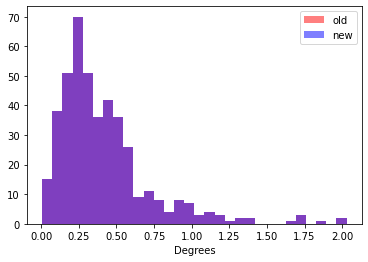

In [28]:
plt.hist(ang_resolution[ang_resolution<3],color='r',alpha=0.5,bins=30,label='old')
plt.hist(ang_resolution_new[ang_resolution_new<3],color='b',alpha=0.5,bins=30,label='new')
plt.xlabel('Degrees')
plt.legend()
plt.savefig('Old_vs_new.png')

In [29]:
np.percentile(ang_resolution_new,50)

0.32931978914527427

In [30]:
np.percentile(ang_resolution,50)

0.32931978914527427

In [31]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmam', 'sigmas', 'A',
       'feimpedance', 'spemean', 'pe_per_vem', 'angular_resolution',
       'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith', 'Laputop_dir_azimuth',
       'Laputop_new_zenith', 'Laputop_new_azimuth', 'Laputop_time',
       'Laputop_pos_x', 'Laputop_pos_y', 't_0', 'Xmax', 'rho', 'z_new'],
      dtype='object')

In [32]:
import matplotlib

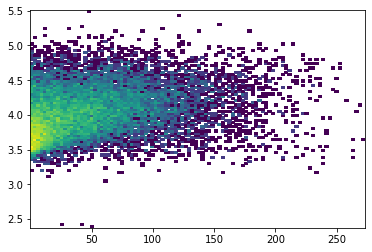

In [33]:
plt.hist2d(abs(df['z_new'])[(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],df['m'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

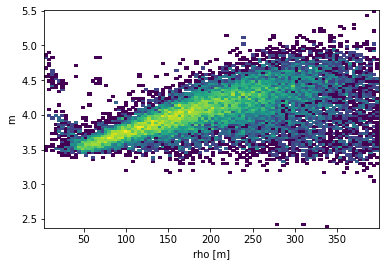

In [34]:
plt.hist2d(df['rho'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],df['m'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel('rho [m]')
plt.ylabel('m')
plt.savefig('check_rho.png')

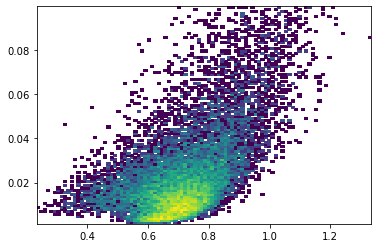

In [35]:
plt.hist2d(df['s'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],df['sigmas'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

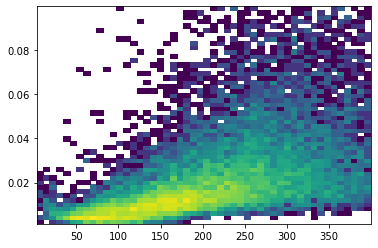

In [36]:
plt.hist2d(df['rho'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],df['sigmas'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],bins=50,norm=matplotlib.colors.LogNorm())
plt.show()

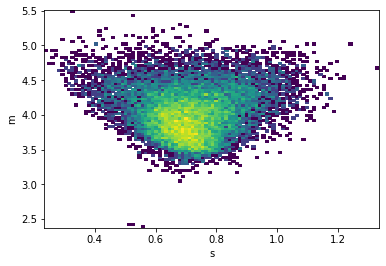

In [37]:
plt.hist2d(df['s'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],df['m'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel('s')
plt.ylabel('m')
plt.savefig('check_s.png')

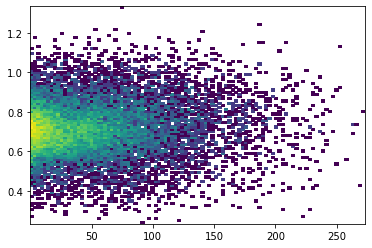

In [38]:
plt.hist2d(abs(df['z_new'])[(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],df['s'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

/home/andy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


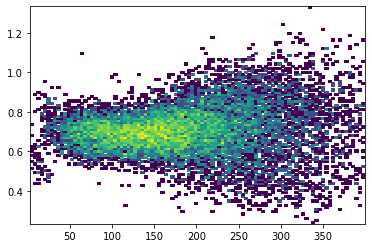

In [39]:
thingy = (np.log10(df['chargeVEM'].values)>0.25)
plt.hist2d(df['rho'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)&thingy],df['s'][(df['sigmam']<0.1)&(df['rho']<400)&(df['sigmas']<0.1)&thingy],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

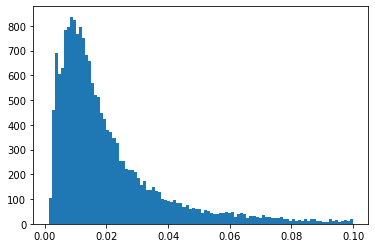

In [40]:
plt.hist(df['sigmam'][df['sigmam']<0.1],bins=100)
plt.show()

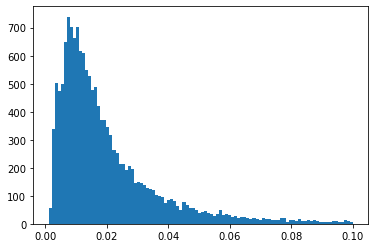

In [41]:
plt.hist(df2['sigmam'][df2['sigmam']<0.1],bins=100)
plt.show()

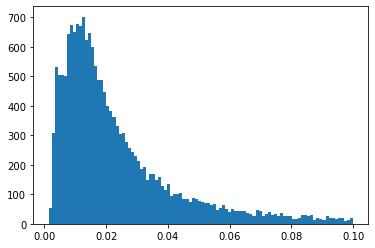

In [42]:
plt.hist(df['sigmas'][df['sigmas']<0.1],bins=100)
plt.show()

In [85]:
print(df.iloc[np.argmax(df['energy'].values)])

Unnamed: 0                  event_672
Unnamed: 1             OMKey(10,63,0)
run_number                      16500
event_number                        4
zenith                       0.291295
azimuth                       5.09929
energy                        7.98091
x                               34.44
y                             -339.47
z                             1945.07
ShowerCOG_x                   442.458
ShowerCOG_y                   142.192
ShowerCOG_z                    1949.7
ShowerCOG_time                10217.4
ShowerCOG_zen                0.277175
ShowerCOG_az                  5.39247
m                             4.07735
s                            0.819518
charge                    2.54933e+17
chargePe                  4.90603e+10
chargeVEM                    0.613543
chi2                          2.61591
sigmam                      0.0227736
sigmas                      0.0294905
A                          0.00057503
feimpedance               8.01088e-18
spemean     

In [87]:
event1 = df.loc[df['Unnamed: 0']=='event_672']
#event1 = df2.loc[df2['Unnamed: 0']=='event_828']

In [88]:
def get_t(t,X,x1,y1,z1,xc,yc,zc,tc):
    x,y,z,r = X
    n = get_n(x1,y1,z1)
    x1 = (x-xc)*n[0]
    x2 = (y-yc)*n[1]
    x3 = (z-zc)*n[2] 
    new = x1 + x2 + x3
    get_delta =  t - tc - (1/c)*np.array(new)
    return t

In [89]:
print((event1['Laputop_dir_zenith'].values[0])*(180/np.pi))
print((event1['Laputop_dir_azimuth'].values[0])*(180/np.pi))

16.649846876547368
289.9195334616297


In [90]:
def func_s(rho,m,b):
    y = m*rho + b
    return y

def func_m(X,A,B,C,D):
    s,rho = X
    y = A + B*rho
    return y

def chisquare_value(observed,true):
    chi2 = np.sum([((i-j)**2)/abs(j) for i,j in zip(observed,true)])

    return chi2

In [91]:
from sklearn.utils import resample

In [92]:
def get_check(function,z,rho,m,chi2,charge,sigma):
    value = []
    value2 = []
    list_values = [240,260,280,300]
    charge_values = [0,0.25,0.5]
    try:
        for charge_value in charge_values:
            check = (np.log10(charge)>charge_value)&(rho<300)
            fit_m = curve_fit(func_m,xdata=[z[check],rho[check]],ydata=m[check],bounds=((1e-10,1e-10,1e-10,1e-10),np.inf),sigma=chi2[check]**0.5)
            chi2_m = chisquare_value(m[check],func_m(np.array([z[check],rho[check]]),fit_m[0][0],fit_m[0][1],fit_m[0][2],fit_m[0][3]))
            value2.append(abs(chi2_m))
            min_charge = charge_values[np.argmin(value2)]

        for max_value in list_values:
            check = (np.log10(charge)>min_charge)&(rho<max_value)
            fit_m = curve_fit(func_m,xdata=[z[check],rho[check]],ydata=m[check],bounds=((1e-10,1e-10,1e-10,1e-10),np.inf),sigma=chi2[check]**0.5)
            chi2_m = chisquare_value(m[check],func_m(np.array([z[check],rho[check]]),fit_m[0][0],fit_m[0][1],fit_m[0][2],fit_m[0][3]))
            value.append(abs(chi2_m))
        max_rho = list_values[np.argmax(value)]
    except:
        min_charge = 0
        max_rho = 300
        
        
    value_new = np.mean(sigma) + np.std(sigma)    

    check = (np.log10(charge)>min_charge)&(rho<list_values[np.argmax(value)])&(sigma<value_new)
    final_fit = curve_fit(func_m,xdata=[z[check],rho[check]],ydata=m[check],bounds=((1e-10,1e-10,1e-10,1e-10),np.inf))
    final_out = func_m([z[check],rho[check]],final_fit[0][0],final_fit[0][1],final_fit[0][2],final_fit[0][3])
    chi2_m = chisquare_value(m[check],func_m(np.array([z[check],rho[check]]),final_fit[0][0],final_fit[0][1],final_fit[0][2],final_fit[0][3]))
    print(chi2_m)
    residual = [(i-j) for i,j in zip(m[check],final_out)]
    
    return check

In [93]:
from functools import partial

In [94]:
def get_check(func_m,rho,m,s,sigma,sigma1,charge):
    check = (rho<400)&(sigma<0.1)&(sigma1<0.1)&(charge>0.25)
    error = np.array([1/i for i in sigma])
    fit_m = curve_fit(func_m,xdata=[s[check],rho[check]],ydata=m[check],bounds=((1e-10,1e-10,1e-10,1e-10),np.inf))

    new_m = func_m([s,rho],fit_m[0][0],fit_m[0][1],fit_m[0][2],fit_m[0][3])
    check = (np.array([(abs(i-j)/j)*100 for i,j in zip(new_m,m)])<=10)&check

    return check

In [95]:
def get_check_s(function,rho,s,sigmas,check):
    error = np.array([1/i for i in sigmas])
    fit_s = curve_fit(function,xdata=rho[check],ydata=s[check],bounds=((1e-10,1e-10),np.inf))

    new_s = function(rho,fit_s[0][0],fit_s[0][1])
    check = (np.array([(abs(i-j)/j)*100 for i,j in zip(new_s,s)])<=10)

    return check

In [96]:
check = get_check(func_m,event1['rho'].values,event1['m'].values,event1['s'].values,event1['sigmam'].values,event1['sigmas'].values,event1['chargeVEM'].values)

/home/andy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [97]:
check_s = get_check_s(func_s,event1['rho'].values,event1['s'].values,event1['sigmas'].values,check)

In [98]:
check_s = check

In [99]:
np.mean(event1['s'][check]),np.std(event1['s'][check])

(0.6754902053698425, 0.1336844441790964)

In [100]:
error = np.sqrt(event1['chi2'][check])

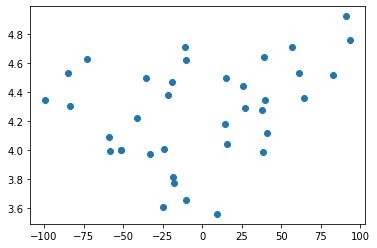

In [101]:
plt.errorbar(event1['z_new'][check],event1['m'][check],fmt='o')
plt.show()

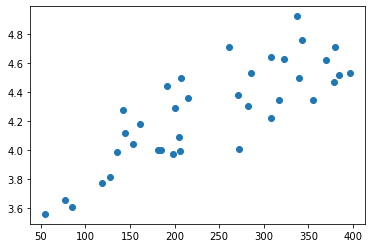

In [102]:
plt.errorbar(abs(event1['rho'])[check_s],event1['m'][check_s],fmt='o')
plt.show()

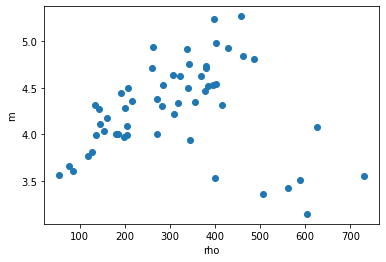

In [103]:
plt.errorbar(event1['rho'],event1['m'],fmt='o')
plt.xlabel('rho')
plt.ylabel('m')
plt.savefig('m_vs_rho.png')

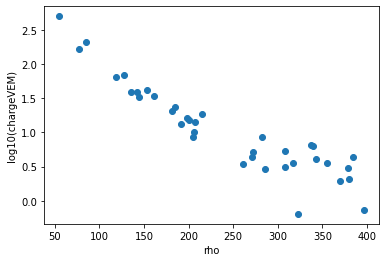

In [104]:
plt.scatter(event1['rho'][check],np.log10(event1['chargeVEM'][check]))
plt.ylabel('log10(chargeVEM)')
plt.xlabel('rho')
plt.savefig('charge_vs_rho.png')

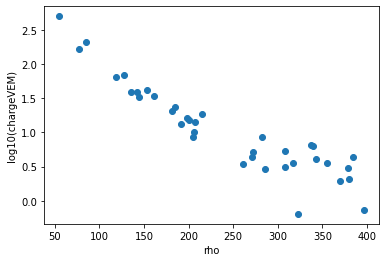

In [105]:
plt.scatter(event1['rho'][check_s],np.log10(event1['chargeVEM'][check_s]))
plt.ylabel('log10(chargeVEM)')
plt.xlabel('rho')
plt.show()

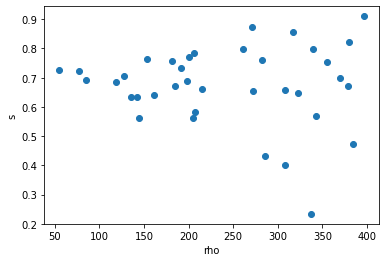

In [106]:
plt.errorbar(event1['rho'][check_s],event1['s'][check_s],fmt='o')
plt.xlabel('rho')
plt.ylabel('s')
plt.savefig('s_vs_rho.png')

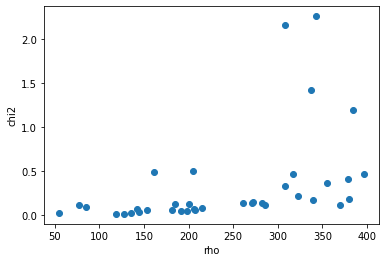

In [107]:
plt.errorbar(event1['rho'][check],event1['chi2'][check],fmt='o')
plt.xlabel('rho')
plt.ylabel('chi2')
plt.show()

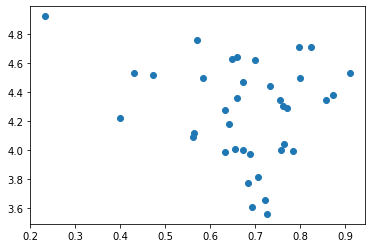

In [108]:
plt.errorbar(event1['s'][check],event1['m'][check],fmt='o')
plt.show()

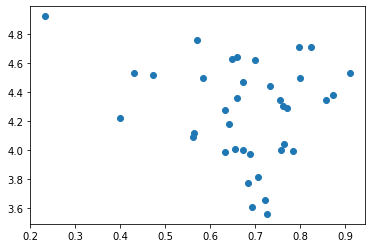

In [109]:
plt.errorbar(event1['s'][check_s],event1['m'][check_s],fmt='o')
plt.show()

In [110]:
error = [1/i for i in event1['chi2'].values[check_s]]

In [111]:
X_new = [event1['s'][check],event1['rho'][check]]

In [112]:
fit = curve_fit(func_m,xdata = X_new,ydata=event1['m'][check])

/home/andy/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [113]:
from functools import partial

In [114]:
X_new1 = [event1['rho'][check],event1['z'][check]]

In [115]:
error = [1/i**0.5 for i in event1['chi2'].values[check]]

In [116]:
fit2 = curve_fit(func_s,xdata = event1['rho'][check],ydata=event1['s'][check],sigma=error,p0 = [1e-4,fit[0][3]])

In [117]:
print(fit)
print(fit2)

(array([3.57604326e+00, 2.86345896e-03, 1.00000000e+00, 1.00000000e+00]), array([[inf, inf, inf, inf],
       [inf, inf, inf, inf],
       [inf, inf, inf, inf],
       [inf, inf, inf, inf]]))
(array([-3.88284269e-04,  6.77948958e-01]), array([[ 1.96569050e-07, -6.12090245e-05],
       [-6.12090245e-05,  2.00029686e-02]]))


In [118]:
m_new = func_m(X_new,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
s_new = func_s(event1['rho'][check_s],fit2[0][0],fit2[0][1])

In [119]:
residual_m = event1['m'][check].values-(m_new)
residual_s = event1['s'][check_s].values-(s_new)

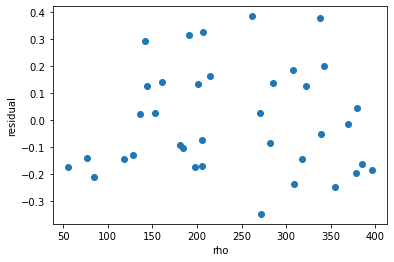

In [120]:
plt.scatter(event1['rho'][check],residual_m)
plt.xlabel('rho')
plt.ylabel('residual')
plt.show()

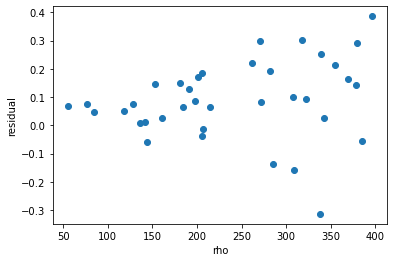

In [121]:
plt.scatter(event1['rho'][check_s],residual_s)
plt.xlabel('rho')
plt.ylabel('residual')
plt.show()

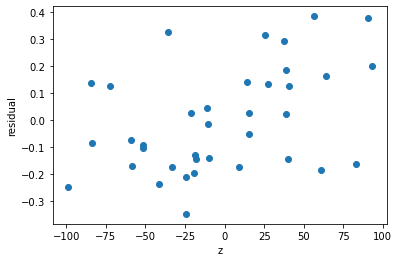

In [122]:
plt.scatter(event1['z_new'][check],residual_m)
plt.xlabel('z')
plt.ylabel('residual')
plt.show()

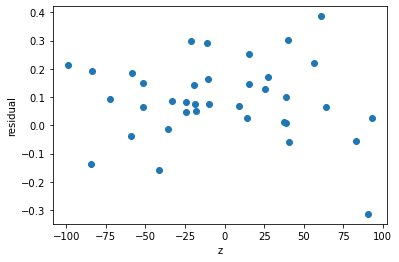

In [123]:
plt.scatter(event1['z_new'][check_s],residual_s)
plt.xlabel('z')
plt.ylabel('residual')
plt.show()

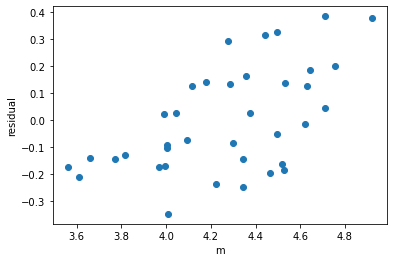

In [124]:
plt.scatter(event1['m'][check],residual_m)
plt.ylabel('residual')
plt.xlabel('m')
plt.show()

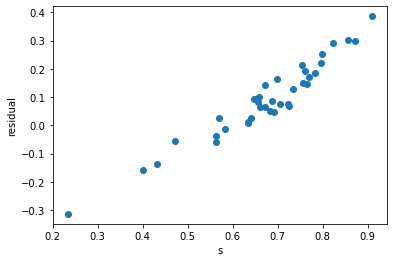

In [125]:
plt.scatter(event1['s'][check_s],residual_s)
plt.ylabel('residual')
plt.xlabel('s')
plt.show()

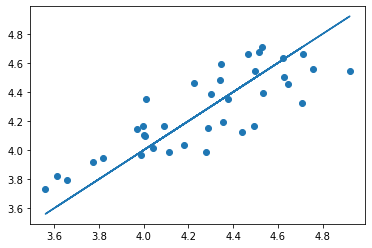

In [126]:
plt.scatter(event1['m'][check],m_new)
plt.errorbar(event1['m'][check],event1['m'][check])
plt.show()

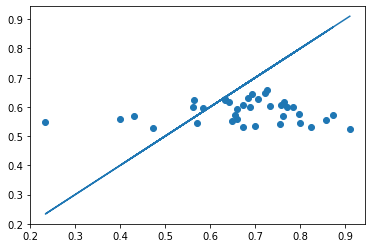

In [127]:
plt.scatter(event1['s'][check_s],s_new)
plt.errorbar(event1['s'][check_s],event1['s'][check_s])
plt.show()

In [128]:
chisquare(event1['m'][check],m_new)[0]

0.316776053641018

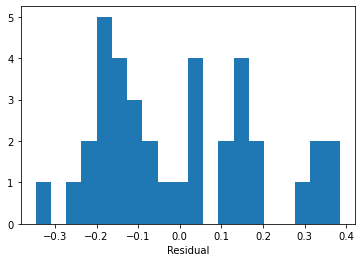

In [129]:
plt.hist(residual_m,bins=20)
plt.xlabel('Residual')
plt.savefig('Residual_event.png')

In [130]:
np.mean(residual_m),np.std(residual_m)

(1.5647231258434338e-10, 0.1913055423257312)

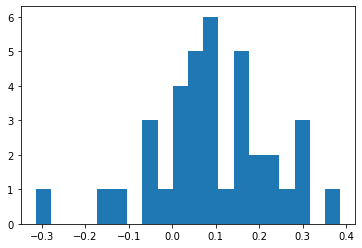

In [131]:
plt.hist(residual_s,bins=20)
plt.show()

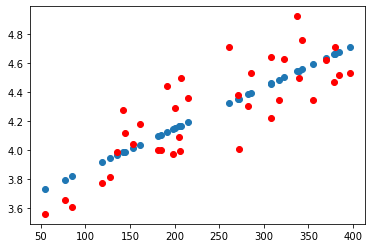

In [132]:
plt.scatter(event1['rho'][check],m_new)
plt.errorbar(event1['rho'][check],event1['m'][check],fmt='o',color='r')
plt.savefig('m_vs_rho.png')

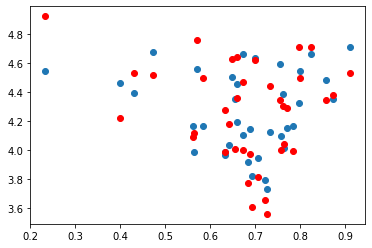

In [133]:
plt.scatter(event1['s'][check],m_new)
plt.errorbar(event1['s'][check],event1['m'][check],fmt='o',color='r')
plt.show()

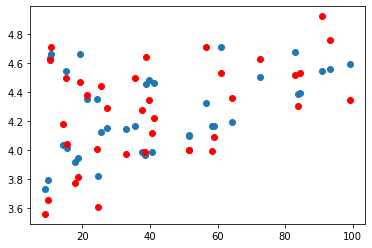

In [134]:
plt.scatter(abs(event1['z_new'][check]),m_new)
plt.errorbar(abs(event1['z_new'][check]),event1['m'][check],fmt='o',color='r')
plt.show()

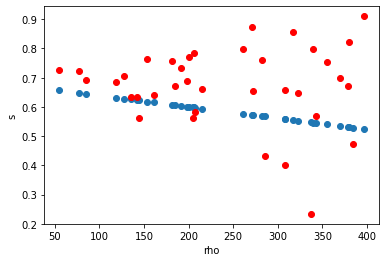

In [135]:
plt.scatter(event1['rho'][check_s],s_new)
plt.errorbar(event1['rho'][check_s],event1['s'][check_s],fmt='o',color='r')
plt.xlabel('rho')
plt.ylabel('s')
plt.savefig('s_rho.png')

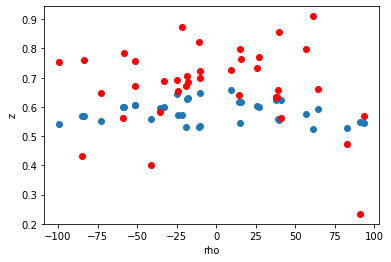

In [136]:
plt.scatter(event1['z_new'][check_s],s_new)
plt.errorbar(event1['z_new'][check_s],event1['s'][check_s],fmt='o',color='r')
plt.xlabel('rho')
plt.ylabel('z')
plt.show()

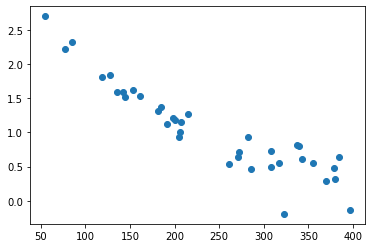

In [137]:
plt.scatter(event1['rho'][check],np.log10(event1['chargeVEM'][check]))
plt.show()

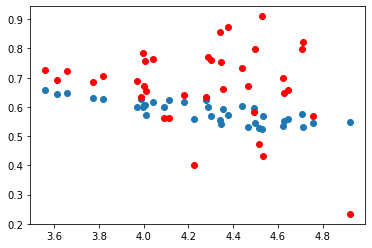

In [138]:
plt.errorbar(event1['m'][check_s],event1['s'][check_s],fmt='o',color='r')
plt.scatter(event1['m'][check_s],s_new)
plt.savefig('m_vs_s.png')

In [139]:
from scipy.stats import chisquare

In [ ]:
A = []
B = []
C = []
m125_1 = []
Xmax = []
rho_value = []
z_value = []
energy = []
s_mean = []
s_std = []
chi2_1 = []

A1 = []
B1 = []
C1 = []
m125_2 = []
Xmax1 = []
rho_value1 = []
z_value1 = []
energy1 = []
s1_mean= []
s1_std = []
chi2_2 = []


for i in events:
    event1 = df.loc[df['Unnamed: 0']==i]

    try:
        check = get_check(func_m,event1['rho'].values,event1['m'].values,event1['s'].values,event1['sigmam'].values,event1['sigmas'].values,event1['chargeVEM'].values)
    except (TypeError,ValueError,RuntimeError,KeyError) as err:
        continue
   
    X_new = [event1['s'].values[check],event1['rho'].values[check]]
    
    if np.sum(check) < 4:
        continue
    
    try:
        fit = curve_fit(func_m,xdata=X_new,ydata=event1['m'].values[check])
        chi2_1.append(chisquare(event1['m'][check],func_m(X_new,fit[0][0],fit[0][1],fit[0][2],fit[0][3]))[0])
    except RuntimeError:
        continue
        
    m125_1.append(func_m([fit[0][2],125],fit[0][0],fit[0][1],fit[0][2],fit[0][3]))
    A.append(fit[0][0])
    B.append(fit[0][1])
    C.append(fit[0][2])
    Xmax.append(event1['Xmax'].values[0])
    z_value.append(event1['z_new'].values)
    rho_value.append(event1['rho'].values)
    energy.append(event1['energy'].values[0])
    s_mean.append(np.mean(event1['s'].values[check]))
    s_std.append(np.std(event1['s'].values[check]))
    
    
for i in events2:
    event1 = df2.loc[df2['Unnamed: 0']==i]
    check = (np.log10(event1['chargeVEM'].values)>0)&(event1['rho'].values<300)&(event1['sigmam']<np.mean(event1['sigmam'])+np.std(event1['sigmam']))
    try:
        check = get_check(func_m,event1['rho'].values,event1['m'].values,event1['s'].values,event1['sigmam'],event1['sigmas'].values,event1['chargeVEM'].values)
    except (TypeError,ValueError,RuntimeError,KeyError) as err:
        continue
    
    error = np.sqrt(event1['chi2'][check])
    X_new = [event1['s'][check],event1['rho'][check]]
    
    if np.sum(check)<4:
        continue
    try:
        fit = curve_fit(func_m,xdata=X_new,ydata=event1['m'][check])  
        chi2_2.append(chisquare(event1['m'][check],func_m(X_new,fit[0][0],fit[0][1],fit[0][2],fit[0][3]))[0])
    except RuntimeError:
        continue
    
    m125_2.append(func_m([fit[0][2],125],fit[0][0],fit[0][1],fit[0][2],fit[0][3]))
    A1.append(fit[0][0])
    B1.append(fit[0][1])
    C1.append(fit[0][2])
    Xmax1.append(event1['Xmax'].values[0])
    z_value1.append(event1['z_new'].values)
    rho_value1.append(event1['rho'].values)
    energy1.append(event1['energy'][check].values[0])
    s1_mean.append(np.mean(event1['s'].values[check]))
    s1_std.append(np.std(event1['s'].values[check]))

/home/andy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/andy/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/andy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
/home/andy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/andy/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/andy/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/andy/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: O

In [ ]:
len(A)

In [ ]:
len(A1)

In [ ]:
energy = np.array(energy)
energy1 = np.array(energy1)
A = np.array(A)
B = np.array(B)
C = np.array(C)
A1 = np.array(A1)
B1 = np.array(B1)
C1 = np.array(C1)
m125_1 = np.array(m125_1)
m125_2 = np.array(m125_2)
Xmax = np.array(Xmax)
Xmax1 = np.array(Xmax1)
s_mean = np.array(s_mean)[energy>7]
s1_mean = np.array(s1_mean)[energy1>7]
s_std = np.array(s_std)[energy>7]
s1_std = np.array(s1_std)[energy1>7]

In [ ]:
plt.hist(C,bins=100)
plt.show()

In [ ]:
print(np.corrcoef(A,Xmax)[0][1],np.corrcoef(B,Xmax)[0][1],np.corrcoef(C,Xmax)[0][1])

In [ ]:
0.21574939174672653 0.231497101470742 0.019306044299974907

In [ ]:
print(np.corrcoef(A1,Xmax1)[0][1],np.corrcoef(B1,Xmax1)[0][1],np.corrcoef(C1,Xmax1)[0][1])

In [ ]:
0.08720071845531845 0.21504764945263605 0.018907957460036564

In [ ]:
np.corrcoef(B,chi2_1)

In [ ]:
plt.hist(A[(A>0)&(A<10)],bins=50,facecolor='w',edgecolor='r',alpha=0.5)
plt.hist(A1[(A1>0)&(A1<10)],bins=50,facecolor='w',edgecolor='g',alpha=0.5)
plt.xlabel('A')
plt.show()

In [ ]:
np.mean(A),np.mean(A1)

In [ ]:
plt.hist(B,bins=50,facecolor='w',edgecolor='r',alpha=0.5,density=True)
plt.hist(B1,bins=50,facecolor='w',edgecolor='g',alpha=0.5,density=True)
plt.xlabel('B')
plt.show()

In [ ]:
np.mean(B[np.isfinite(B)]),np.mean(B1[np.isfinite(B1)])

In [ ]:
plt.hist(C,bins=50,facecolor='w',edgecolor='r',alpha=0.5,density=True)
plt.hist(C1,bins=50,facecolor='w',edgecolor='g',alpha=0.5,density=True)
plt.show()

In [ ]:
np.mean(C),np.mean(C1)

In [ ]:
plt.hist(np.hstack(rho_value),bins=100)
plt.hist(np.hstack(rho_value1),bins=100)
plt.xlabel('rho')
plt.savefig('rho_distribution.png')

In [ ]:
plt.hist(np.hstack(z_value),bins=100)
plt.hist(np.hstack(z_value1),bins=100)
plt.xlabel('z')
plt.savefig('z_value.png')

In [ ]:
import matplotlib
plt.hist2d(np.array(Xmax),A,bins=30,norm =matplotlib.colors.LogNorm() )
plt.show()

In [ ]:
check = (A1>0)&(A1<10)
plt.hist2d(np.array(Xmax1)[check],A1[check],bins=50,norm =matplotlib.colors.LogNorm() )
plt.show()

In [ ]:
def line(m,x,b):
    y = m * x + b
    return y

In [ ]:
B_new = np.append(B,B1)
new_xmax = np.append(Xmax,Xmax1)
#fit_new = curve_fit(line,B_new,new_xmax)

plt.hist2d(new_xmax[np.isfinite(B_new)],B_new[np.isfinite(B_new)],bins=100,norm =matplotlib.colors.LogNorm())
#plt.plot(B_new,line(B_new,fit_new[0][0],fit_new[0][1]))
plt.xlabel('slope')
plt.ylabel('Xmax')
plt.savefig('Xmax_vs_slope.png')

In [ ]:
np.corrcoef(np.append(C,C1)[np.isfinite(B_new)],new_xmax[np.isfinite(B_new)])[0][1]

In [ ]:
new_C = np.append(C,C1)

In [ ]:
plt.hist2d(new_C,new_xmax,bins=100,norm =matplotlib.colors.LogNorm() )
plt.show()

In [ ]:
plt.hist(np.array(m125_1)[(m125_1>3)&(m125_1<5)],bins=50,alpha=0.5)
plt.hist(np.array(m125_2)[(m125_2>3)&(m125_2<5)],bins=50,alpha=0.5)
plt.show()

In [ ]:
np.mean(m125_1),np.mean(m125_2)

In [ ]:
m_125_new = np.append(m125_1,m125_2)

In [ ]:
plt.hist2d(m_125_new,new_xmax,bins=20,norm =matplotlib.colors.LogNorm() )
plt.xlabel('m_125')
plt.ylabel('Xmax')
plt.savefig('Xmax_vs_m_125.png')

In [ ]:
np.corrcoef(m_125_new,new_xmax)[0][1]

In [ ]:
plt.hist2d(m_125_new,np.append(energy,energy1),bins=20,norm =matplotlib.colors.LogNorm() )
plt.show()

In [ ]:
plt.hist(m125_1,bins=100,alpha=0.5)
plt.hist(m125_2,bins=100,alpha=0.5)
plt.show()